# Feature Selection with down and upsampling

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,k9,k12,alcohol_use,k21a,k21b,risk_of_use,risk_of_try,cannabis_access,other_access,...,k70b_3.0,k70b_4.0,k70c_2.0,k70c_3.0,k70c_4.0,k70d_2.0,k70d_3.0,k70d_4.0,k70e_3.0,k70e_4.0
0,0.0,4.0,4.0,7.0,2.0,1.0,20.0,13.0,2.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,3.0,3.0,6.0,3.0,3.0,22.0,14.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,5.0,5.0,7.0,3.0,2.0,21.0,13.0,2.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,3.0,5.0,6.0,2.0,1.0,22.0,11.0,3.0,3.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,3.0,5.0,6.0,2.0,3.0,21.0,12.0,1.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.934577
1.0    0.065423
Name: kannabis, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [5]:
print('Dimension of X train: ', X_train.shape)
print('Target 1: ', np.count_nonzero(y_train == 1))
print('Target 0: ', np.count_nonzero(y_train == 0))



print('\n ---------------------\n')
print('Dimension of X test :', X_test.shape)
print('Target 1: ', np.count_nonzero(y_test == 1))
print('Target 0: ', np.count_nonzero(y_test == 0))




Dimension of X train:  (2439, 60)
Target 1:  160
Target 0:  2279

 ---------------------

Dimension of X test : (1046, 60)
Target 1:  68
Target 0:  978


### Scaling
Robust Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [6]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
X_train_std = robust.fit_transform(X_train)
X_test_std = robust.transform(X_test)

# Oversampling

In [7]:
# Oversampling with SMOTE 

# Because the Target is imbalance, i try to balance the data with SMOTE(OverSampling)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=46)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
#X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print('Dimension of X train with SMOTE: ', X_train_res.shape)
print('\n -------------- ')
print('Target 1 after SMOTE: ', np.count_nonzero(y_train_res == 1))
print('Target 0 after SMOTE: ', np.count_nonzero(y_train_res == 0))





Dimension of X train with SMOTE:  (4558, 60)

 -------------- 
Target 1 after SMOTE:  2279
Target 0 after SMOTE:  2279


# Random Forest

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np

In [9]:
from sklearn.ensemble import RandomForestClassifier

rfecv_rfauto= RFECV(estimator=RandomForestClassifier())

model_rfauto = RandomForestClassifier(n_estimators=1000, random_state=92116)

In [10]:
pipeline_rfauto = Pipeline([('Feature Selection', rfecv_rfauto), ('Model', model_rfauto)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline_rfauto, X_train_std, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.957280914794576

In [11]:
pipeline_rfauto.fit(X_train_std, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=RandomForestClassifier())),
                ('Model',
                 RandomForestClassifier(n_estimators=1000,
                                        random_state=92116))])

In [31]:
print('Optimal number of features : %d' % rfecv_rfauto.n_features_)

Optimal number of features : 26


In [13]:
rfecv_rfauto.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True, False,
       False, False,  True, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
        True, False, False, False,  True,  True])

In [14]:
y_pred = pipeline_rfauto.predict(X_test_std)

Accuracy: 0.9618
Precision: 0.9592
Recall: 0.9618
F1 Score: 0.96
Cohen Kappa Score: 0.6573
Matthews Corrcoef: 0.6608
roc_auc_score: 0.8016660651990858
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       990
         1.0       0.62      0.75      0.68        56

    accuracy                           0.96      1046
   macro avg       0.80      0.86      0.83      1046
weighted avg       0.97      0.96      0.96      1046

Confusion Matrix:
 [[964  14]
 [ 26  42]]


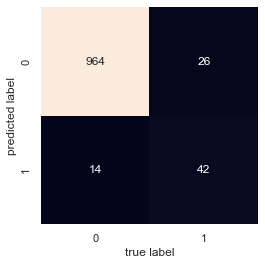

In [71]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# RFE GradientBoostingClassifier

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=GradientBoostingClassifier())
model = GradientBoostingClassifier()

In [73]:
pipelinegbc = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipelinegbc, X_train_std, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9560493827160496

In [74]:
pipelinegbc.fit(X_train_std, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=GradientBoostingClassifier())),
                ('Model', GradientBoostingClassifier())])

In [75]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 15


In [76]:
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv.support_rfecv_df.head(15)

,Rank
k9,1
drug_offer_1,1
drug_user_friend_1,1
k23d_2.0,1
k70b_3.0,1
k70b_4.0,1
non_medicide_1,1
k70c_4.0,1
doping_access,1
k6_2.0,1


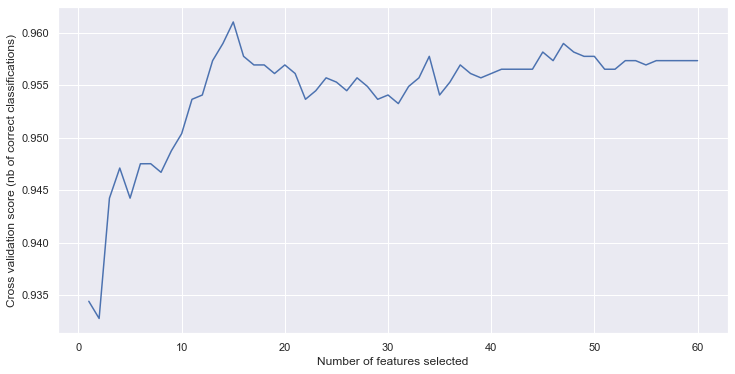

In [77]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [78]:
y_pred = pipelinegbc.predict(X_test_std)

Accuracy: 0.9637
Precision: 0.9627
Recall: 0.9637
F1 Score: 0.9632
Cohen Kappa Score: 0.6928
Matthews Corrcoef: 0.6931
roc_auc_score: 0.8368970287501504
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       982
         1.0       0.69      0.73      0.71        64

    accuracy                           0.96      1046
   macro avg       0.84      0.86      0.85      1046
weighted avg       0.96      0.96      0.96      1046

Confusion Matrix:
 [[961  17]
 [ 21  47]]


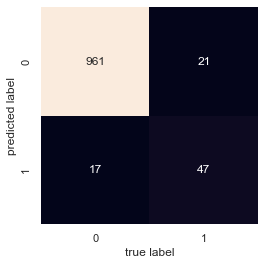

In [79]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# SVC

In [82]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

rfecv_SVC = RFECV(estimator=svc)

model = SVC(kernel="linear")

In [83]:
pipelinesvc = Pipeline([('Feature Selection', rfecv_SVC), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipelinesvc, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9563792754503138

In [84]:
pipelinesvc.fit(X_train,y_train)

Pipeline(steps=[('Feature Selection', RFECV(estimator=SVC(kernel='linear'))),
                ('Model', SVC(kernel='linear'))])

In [85]:
print('Optimal number of features : %d' % rfecv_SVC.n_features_)

Optimal number of features : 22


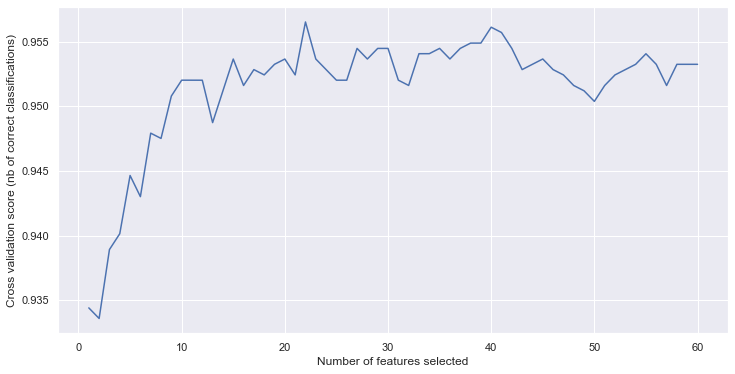

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv_SVC.grid_scores_) + 1), rfecv_SVC.grid_scores_)
plt.show()

In [87]:
y_pred = pipelinesvc.predict(X_test_std)

Accuracy: 0.8031
Precision: 0.9498
Recall: 0.8031
F1 Score: 0.8507
Cohen Kappa Score: 0.3238
Matthews Corrcoef: 0.436
roc_auc_score: 0.8878413328521593
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      1.00      0.88       774
         1.0       0.99      0.25      0.39       272

    accuracy                           0.80      1046
   macro avg       0.89      0.62      0.64      1046
weighted avg       0.84      0.80      0.76      1046

Confusion Matrix:
 [[773 205]
 [  1  67]]


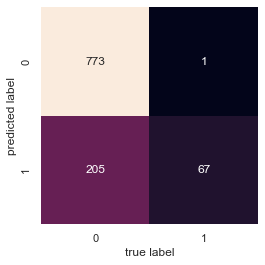

In [88]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# Downsampling

In [89]:
w_class0 = np.where(y == 0)[0]
w_class1 = np.where(y == 1)[0]

n_class0 = len(w_class0) 
n_class1 = len(w_class1)
 

print("n_class0: ", n_class0)
print("n_class1: ", n_class1)

n_class0:  3257
n_class1:  228


In [90]:
w_class1_downsampled = np.random.choice(w_class1, size=n_class0)

print()
print(np.hstack((y[w_class0], y[w_class1_downsampled])))




[0. 0. 0. ... 1. 1. 1.]


In [91]:
no_cannabis = data[data["kannabis"] == 0]
yes_cannabis  = data[data["kannabis"] == 1]
print(no_cannabis.shape)
print(yes_cannabis.shape)

(3257, 61)
(228, 61)


In [92]:
from sklearn.utils import resample
cannabis_downsample = resample(no_cannabis,
             replace=True,
             n_samples=len(yes_cannabis),
             random_state=42)

print(cannabis_downsample.shape)

(228, 61)


0.0    228
1.0    228
Name: kannabis, dtype: int64


<AxesSubplot:ylabel='Type'>

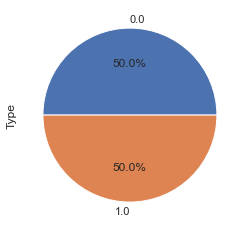

In [93]:
data_downsampled = pd.concat([cannabis_downsample, yes_cannabis])
print(data_downsampled["kannabis"].value_counts())

data_downsampled.groupby('kannabis').size().plot(kind='pie',
                                       y = "kannabis",
                                       label = "Type",
                                       autopct='%1.1f%%')


In [94]:
from sklearn.model_selection import train_test_split

X, y = data_downsampled.iloc[:, 1:].values, data_downsampled.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
rfecv = RFECV(estimator=GradientBoostingClassifier())
model = GradientBoostingClassifier()

In [96]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9041532258064516

In [97]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=GradientBoostingClassifier())),
                ('Model', GradientBoostingClassifier())])

In [98]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 12


In [99]:
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv.support_rfecv_df.head(15)

,Rank
k9,1
k23d_2.0,1
drug_offer_1,1
e_cigarette_1,1
k72,1
k70b_3.0,1
cannabis_access,1
drug_user_friend_1,1
risk_of_use,1
k70b_4.0,1


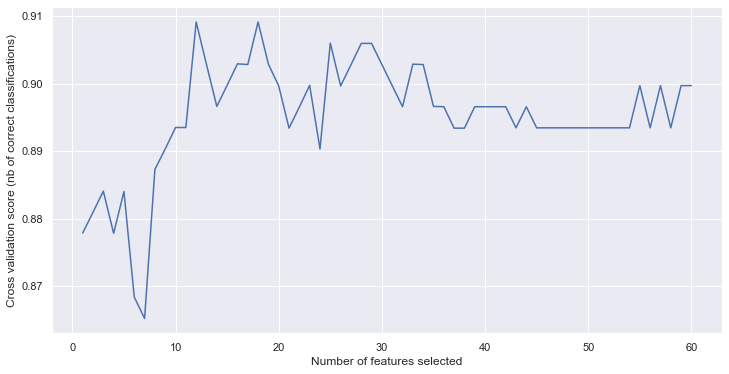

In [100]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

<AxesSubplot:>

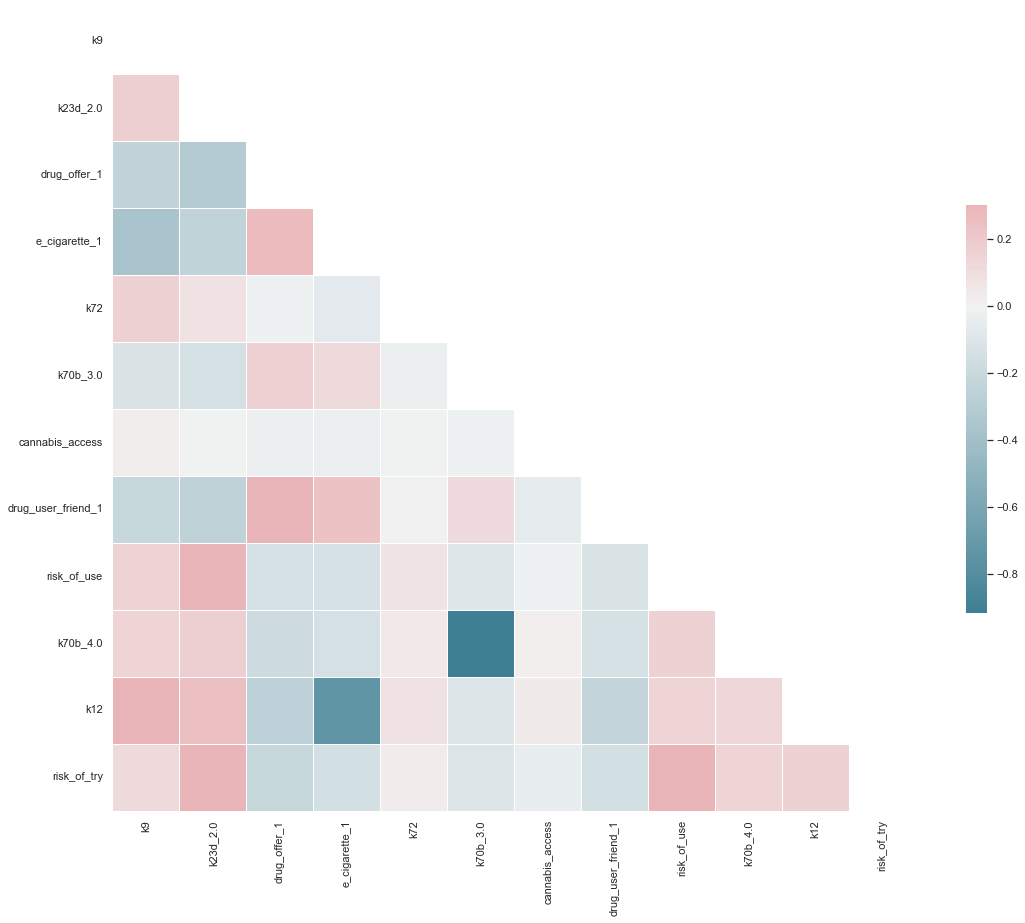

In [131]:
dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
dt_columns = list(np.array(dt_columns['index']))

# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = data[dt_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, )
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

In [101]:
y_pred = pipeline.predict(X_test)

Accuracy: 0.854
Precision: 0.8552
Recall: 0.854
F1 Score: 0.8539
Cohen Kappa Score: 0.7079
Matthews Corrcoef: 0.7091
roc_auc_score: 0.8537936913895993
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.84      0.86        73
         1.0       0.82      0.88      0.85        64

    accuracy                           0.85       137
   macro avg       0.85      0.86      0.85       137
weighted avg       0.86      0.85      0.85       137

Confusion Matrix:
 [[61  8]
 [12 56]]


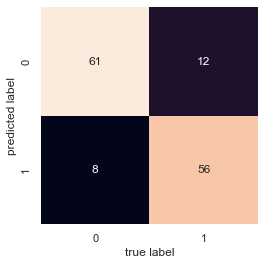

In [102]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# Random Forest 

In [103]:
from sklearn.ensemble import RandomForestClassifier

rfecv_rfauto= RFECV(estimator=RandomForestClassifier())

model_rfauto = RandomForestClassifier(n_estimators=1000, random_state=92116)

In [105]:
pipeline_rfauto = Pipeline([('Feature Selection', rfecv_rfauto), ('Model', model_rfauto)])
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline_rfauto, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9040725806451612

In [107]:
pipeline_rfauto.fit(X_train, y_train)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=RandomForestClassifier())),
                ('Model',
                 RandomForestClassifier(n_estimators=1000,
                                        random_state=92116))])

In [110]:
print('Optimal number of features : %d' % rfecv_rfauto.n_features_)

Optimal number of features : 15


<AxesSubplot:>

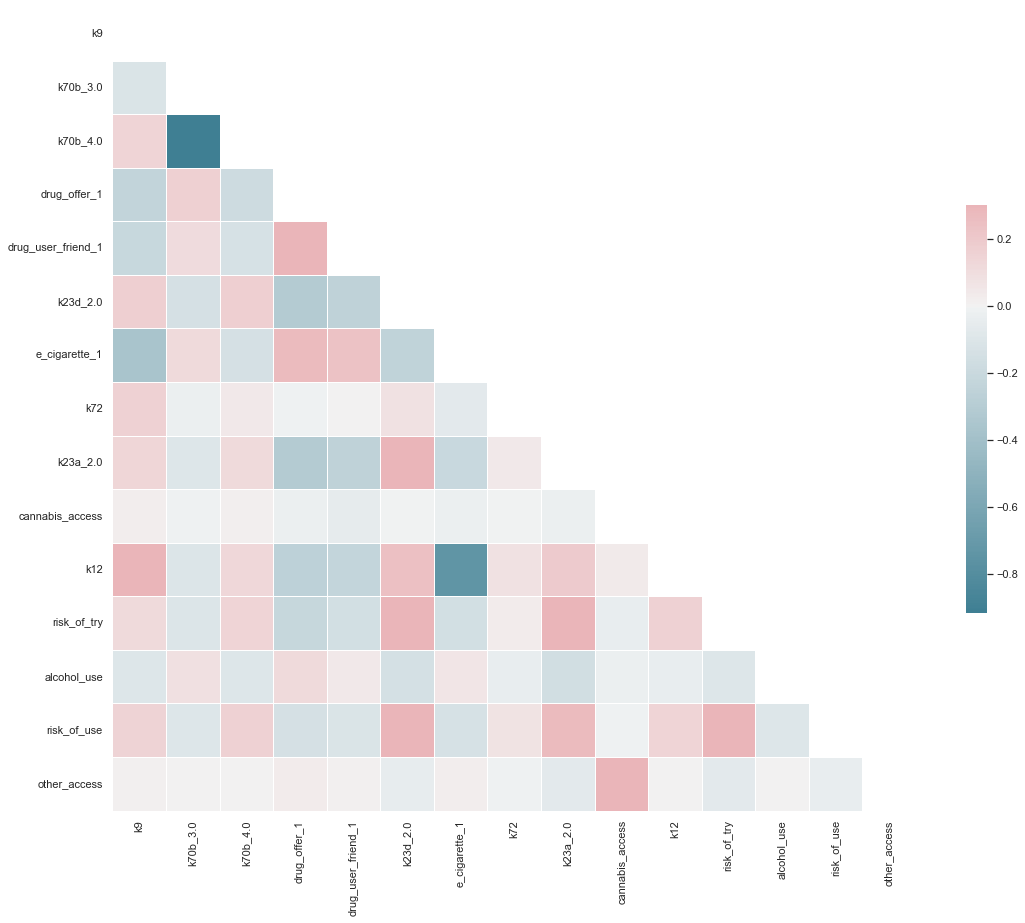

In [132]:
rfecv_rfauto.support_rfecv_df = pd.DataFrame(rfecv_rfauto.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

dt_columns = rfecv_rfauto.support_rfecv_df [rfecv_rfauto.support_rfecv_df ['Rank']==1].reset_index()
dt_columns = list(np.array(dt_columns['index']))

# New Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = data[dt_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, )
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [108]:
y_pred = pipeline_rfauto.predict(X_test)

Accuracy: 0.8832
Precision: 0.8845
Recall: 0.8832
F1 Score: 0.8831
Cohen Kappa Score: 0.7663
Matthews Corrcoef: 0.7676
roc_auc_score: 0.882992327365729
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.86      0.89        73
         1.0       0.85      0.91      0.88        64

    accuracy                           0.88       137
   macro avg       0.88      0.88      0.88       137
weighted avg       0.88      0.88      0.88       137

Confusion Matrix:
 [[63  6]
 [10 58]]


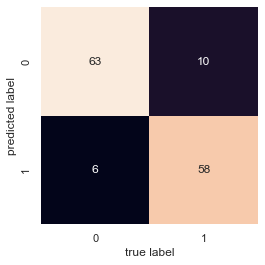

In [109]:
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# Sonuc ve Sorular

1. Pipeline accuracy ile model.prediction uzerinden elde edilen degerler cok az farkli. Herhangi bir sorun var mi? 
2. Downsampling de accuracy, F1 gibi degeler daha dusuk ama Cohen Kappa ve Matthews corrcoef yukseldi. Smote ile uretilen sampling sonuclarinda Cohen Kappa ve Matthews corrcoef yukseldi. Bu nasil dengelenecek?
3. Random Forest with Smote 26 features vs RF downsampling 15 features
4. GBC with Smote 15 vs GBC with downsampling 12
5. SVC en kotu sonuclari verdi
6. Downsampling de RF sonuclari daha iyi
